# batch_normalization 과 drop out을 같이 사용하면 성능이 안좋아진다.

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd

import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("./data/")

C:\Users\p\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
X_train = mnist.train.images
X_test = mnist.test.images
y_train = mnist.train.labels.astype("int")
y_test = mnist.test.labels.astype("int")

In [5]:
import tensorflow as tf

n_inputs = 28*28  # MNIST
n_hidden1 = 500
n_hidden2 = 300
n_outputs = 10

In [6]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

# For batch Normalization
training = tf.placeholder_with_default(False, shape=(), name='training')

In [7]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        
        #He Initialization
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

# drop out

In [8]:
with tf.name_scope("dnn"):
    # with ELU and batchNormalization
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.layers.batch_normalization(hidden1, training = training,
                                       momentum = 0.9)
    bn1_act = tf.nn.elu(bn1)
    
    hidden1_drop = tf.layers.dropout(bn1_act,rate=0.5,training=training)
    hidden2 = neuron_layer(hidden1_drop, n_hidden2, name="hidden2")
    bn2 = tf.layers.batch_normalization(hidden2, training = training,
                                   momentum = 0.9)
    bn2_act = tf.nn.elu(bn2)
    hidden2_drop = tf.layers.dropout(bn2_act,rate=0.5,training=training)

#    logits_before_bn = neuron_layer(bn2_act, n_outputs, name="outputs")
#    logits = tf.layers.batch_normalization(logits_before_bn, training = training,
#                                          momentum = 0.9)
    
    n_hidden3 = 100
    hidden3 = neuron_layer(hidden2_drop, n_hidden3, name="hidden2")
    bn3 = tf.layers.batch_normalization(hidden3, training = training,
                                   momentum = 0.9)
    bn3_act = tf.nn.elu(bn3)
    hidden2_drop = tf.layers.dropout(bn3_act,rate=0.5,training=training)

    logits_before_bn = neuron_layer(hidden2_drop, n_outputs, name="outputs")
    logits = tf.layers.batch_normalization(logits_before_bn, training = training,
                                          momentum = 0.9)

    
    

# batch normalization

In [122]:
with tf.name_scope("dnn"):
    # with ELU and batchNormalization
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.layers.batch_normalization(hidden1, training = training,
                                       momentum = 0.9)
    bn1_act = tf.nn.elu(bn1)
    
    hidden2 = neuron_layer(bn1_act, n_hidden2, name="hidden2")
    bn2 = tf.layers.batch_normalization(hidden2, training = training,
                                   momentum = 0.9)
    bn2_act = tf.nn.elu(bn2)
    
#    logits_before_bn = neuron_layer(bn2_act, n_outputs, name="outputs")
#    logits = tf.layers.batch_normalization(logits_before_bn, training = training,
#                                          momentum = 0.9)
    
    n_hidden3 = 100
    hidden3 = neuron_layer(bn2_act, n_hidden3, name="hidden2")
    bn3 = tf.layers.batch_normalization(hidden3, training = training,
                                   momentum = 0.9)
    bn3_act = tf.nn.elu(bn3)

    logits_before_bn = neuron_layer(bn3_act, n_outputs, name="outputs")
    logits = tf.layers.batch_normalization(logits_before_bn, training = training,
                                          momentum = 0.9)

    
    

In [9]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [10]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [11]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [12]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [13]:
n_epochs = 30
batch_size = 32

In [16]:
ACC_Train_List = []
ACC_Test_List = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,
                                            y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        ACC_Train_List.append(acc_train)
        ACC_Test_List.append(acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Train accuracy: 1.0 Test accuracy: 0.9544
1 Train accuracy: 1.0 Test accuracy: 0.957
2 Train accuracy: 0.9375 Test accuracy: 0.9671
3 Train accuracy: 0.96875 Test accuracy: 0.9722
4 Train accuracy: 1.0 Test accuracy: 0.971
5 Train accuracy: 1.0 Test accuracy: 0.9713
6 Train accuracy: 1.0 Test accuracy: 0.9717
7 Train accuracy: 1.0 Test accuracy: 0.9696
8 Train accuracy: 0.96875 Test accuracy: 0.9736
9 Train accuracy: 1.0 Test accuracy: 0.9771
10 Train accuracy: 1.0 Test accuracy: 0.9751
11 Train accuracy: 0.96875 Test accuracy: 0.9743
12 Train accuracy: 1.0 Test accuracy: 0.9757
13 Train accuracy: 1.0 Test accuracy: 0.9768
14 Train accuracy: 1.0 Test accuracy: 0.9779
15 Train accuracy: 0.9375 Test accuracy: 0.9754
16 Train accuracy: 0.96875 Test accuracy: 0.9677
17 Train accuracy: 1.0 Test accuracy: 0.9767
18 Train accuracy: 1.0 Test accuracy: 0.9751
19 Train accuracy: 1.0 Test accuracy: 0.9745
20 Train accuracy: 1.0 Test accuracy: 0.98
21 Train accuracy: 1.0 Test accuracy: 0.9806
22

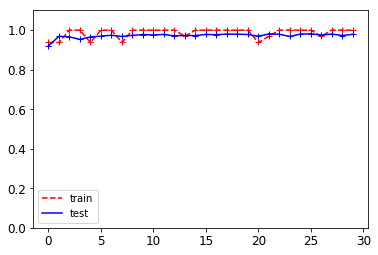

In [15]:
plt.plot(ACC_Train_List,'r--',label = "train")
plt.plot(ACC_Train_List,'r+')
plt.plot(ACC_Test_List, 'b-',label = "test")
plt.plot(ACC_Test_List, 'b+')
plt.ylim(0,1.1)
plt.legend()
plt.show()

In [130]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = mnist.test.images[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [131]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", mnist.test.labels[:20])

Predicted classes: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [132]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [41]:
show_graph(tf.get_default_graph())